In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import mlflow
import dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import jax.random
%matplotlib inline

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)), 'src')
sys.path.append(MODULE_DIR)

try:
    PLOT_BASE_DIR = os.path.abspath(os.environ["PLOT_BASE_DIR"])
except KeyError:
    raise RuntimeError("Missing plot output dir. Set the PLOT_BASE_DIR variable accordingly")
os.makedirs(PLOT_BASE_DIR, exist_ok=True)


In [4]:
import data


In [5]:
# Load data
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("paper_filter_size_synthetic")

token = None
run_records = []
while True:
    runs = client.search_runs(experiment.experiment_id, page_token=token)
    token = runs.token
    for run in runs:
        run_dict = {
            "id": run.info.run_id,
            "status": run.info.status,
        }
        run_dict.update(run.data.params)
        run_dict.update(run.data.metrics)
        run_dict.update({
            f"tags.{tag}": value for tag, value in run.data.tags.items()
        })
        run_records.append(run_dict)

    if token is None:
        break

df_runs = pd.DataFrame.from_records(run_records)

df_runs_noninterp = df_runs[df_runs.train_accuracy < 1]
if len(df_runs_noninterp) > 0:
    df_runs_noninterp = df_runs_noninterp[
        ["id", "network_filter_size", "network_width", "noise_fraction", "seed", "training_seed",
         "train_accuracy", "train_loss"]
    ]
    print(f"Found non-interpolating runs:\n{df_runs_noninterp}")
df_runs = df_runs[df_runs.train_accuracy == 1.0]

df_runs_fail = df_runs[(df_runs.status != "FINISHED")]
if len(df_runs_fail) > 0:
    df_runs_fail = df_runs_fail[
        ["id", "network_filter_size", "network_width", "noise_fraction", "seed", "training_seed",
         "train_accuracy", "train_loss"]
    ]
    print(f"Found failed runs:\n{df_runs_fail}")
df_runs = df_runs[df_runs.status == "FINISHED"]

assert (df_runs.status == "FINISHED").all()
assert (df_runs.train_accuracy == 1.0).all()

print(f"Have a total of {len(df_runs)} runs")

COLUMNS_SETTING = [
    "noise_fraction", "network_width", "network_filter_size"
]
COLUMNS_SETTING_FULL = ["seed"] + COLUMNS_SETTING
COLUMNS_METRICS = [
    "best_final_test_accuracy_diff", "best_test_accuracy", "test_accuracy",
    "train_accuracy", "train_loss"
]
COLUMNS = COLUMNS_SETTING_FULL + COLUMNS_METRICS

df_runs = df_runs.set_index("id")
df_runs_full = df_runs
df_runs = df_runs[COLUMNS]

df_runs.network_filter_size = df_runs.network_filter_size.astype(int)
df_runs.network_width = df_runs.network_width.astype(int)

# Aggregate over inner seeds; treat as one quantity
df_agg = df_runs.groupby(COLUMNS_SETTING_FULL).agg("mean").reset_index()

# Load early-stopped train accuracy for all runs
early_stopped_accuracies = {}
early_stopped_noise_accuracies = {}
early_stopping_epochs = {}
for idx, run_id in enumerate(df_runs.index):
    best_test_accuracy = max(client.get_metric_history(run_id, key="test_accuracy"), key=lambda metric: metric.value)
    best_epoch = best_test_accuracy.step
    early_stopping_epochs[run_id] = best_epoch
    train_accuracies = client.get_metric_history(run_id, key="train_accuracy")
    early_stopped_train_accuracy, = filter(lambda metric: metric.step == best_epoch, train_accuracies)
    early_stopped_accuracies[run_id] = early_stopped_train_accuracy.value

    if df_runs.loc[run_id]["noise_fraction"] == "0.2":
        train_noise_accuracies = client.get_metric_history(run_id, key="train_noise_accuracy")
        early_stopped_noise_accuracy, = filter(lambda metric: metric.step == best_epoch, train_noise_accuracies)
        early_stopped_noise_accuracies[run_id] = early_stopped_noise_accuracy.value
    else:
        early_stopped_noise_accuracies[run_id] = 0.0

    if (idx + 1) % 1000 == 0 or (idx + 1) == len(df_runs):
        print(f"Processed {idx + 1}/{len(df_runs)} runs")

df_runs["es_train_accuracy"] = pd.Series(early_stopped_accuracies)
df_runs["es_train_noise_accuracy"] = pd.Series(early_stopped_noise_accuracies)
df_runs["es_train_noiseless_accuracy"] = (
    df_runs["es_train_accuracy"] - df_runs["noise_fraction"].astype(float) * df_runs["es_train_noise_accuracy"]
) / (1.0 - df_runs["noise_fraction"].astype(float))
df_runs["es_train_epoch"] = pd.Series(early_stopping_epochs)
df_agg = df_runs.groupby(COLUMNS_SETTING_FULL).agg("mean").reset_index()

Found non-interpolating runs:
                                    id network_filter_size network_width  \
8072  e1ceda2e9e2349949da0c4b0fcc88742                   5           128   
8086  f1da7963197d424b87725c1305975617                   5           128   

     noise_fraction seed training_seed  train_accuracy  train_loss  
8072            0.2    4             2            0.99    0.046860  
8086            0.2    1             2            0.99    0.032887  
Have a total of 8098 runs


/tmp/ipykernel_25414/603544933.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.network_filter_size = df_runs.network_filter_size.astype(int)
/tmp/ipykernel_25414/603544933.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.network_width = df_runs.network_width.astype(int)


Processed 1000/8098 runs
Processed 2000/8098 runs
Processed 3000/8098 runs
Processed 4000/8098 runs
Processed 5000/8098 runs
Processed 6000/8098 runs
Processed 7000/8098 runs
Processed 8000/8098 runs
Processed 8098/8098 runs


/tmp/ipykernel_25414/603544933.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs["es_train_accuracy"] = pd.Series(early_stopped_accuracies)
/tmp/ipykernel_25414/603544933.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs["es_train_noise_accuracy"] = pd.Series(early_stopped_noise_accuracies)
/tmp/ipykernel_25414/603544933.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [6]:
import plot_util
plot_util.setup_matplotlib()

In [7]:
NOISE_ES_STYLE_MAP = {
    "0.0": {"int": ("C0", plot_util.LINESTYLE_MAP[1]), "es": ("C1", plot_util.LINESTYLE_MAP[1])},
    "0.2": {"int": ("C0", plot_util.LINESTYLE_MAP[0]), "es": ("C1", plot_util.LINESTYLE_MAP[0])},
}

ABLATION_NOISE_STYLE_MAP = {
    "0.0": [(f"C{idx}", plot_util.LINESTYLE_MAP[1]) for idx in range(5)],
    "0.2": [(f"C{idx}", plot_util.LINESTYLE_MAP[0]) for idx in range(5)],
}

ABLATION_MODEL_STYLE_MAP = {
    "int": [(f"C{idx}", plot_util.LINESTYLE_MAP[0]) for idx in range(5)],
    "es": [(f"C{idx}", plot_util.LINESTYLE_MAP[1]) for idx in range(5)],
}


## Test error curve

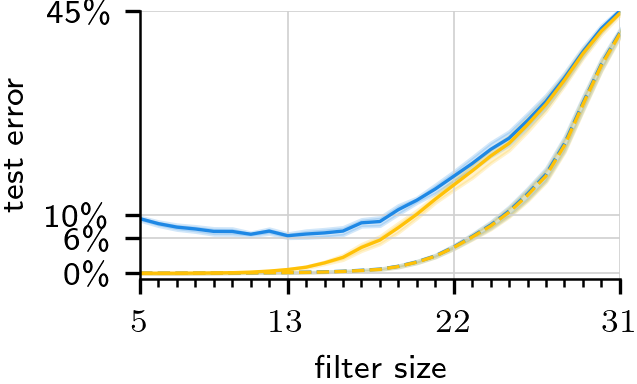

In [8]:
fig, ax = plt.subplots(
    figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5] / plot_util.GOLDEN_RATIO)
)

df_test_error = df_agg.loc[df_agg.network_width == 128].drop(
    ["network_width"], axis=1
).groupby(["noise_fraction", "network_filter_size"]).agg(["mean", "sem"])
for noise_idx, noise_fraction in enumerate(df_test_error.index.get_level_values(0).unique()):
    df_setting_noise = df_test_error.loc[noise_fraction]
    network_depth = df_setting_noise.index
    xs = network_depth
    ys_mean = 1.0 - df_setting_noise["test_accuracy"]["mean"]
    ys_err = df_setting_noise["test_accuracy"]["sem"]
    current_color, current_ls = NOISE_ES_STYLE_MAP[noise_fraction]["int"]
    ax.fill_between(
        xs,
        ys_mean - ys_err,
        ys_mean + ys_err,
        color=current_color,
        alpha=0.2,
    )
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"{float(noise_fraction)*100:.0f}\% noise",
        ls=current_ls,
    )

    ys_mean = 1.0 - df_setting_noise["best_test_accuracy"]["mean"]
    ys_err = df_setting_noise["best_test_accuracy"]["sem"]
    current_color, current_ls = NOISE_ES_STYLE_MAP[noise_fraction]["es"]
    ax.fill_between(
        xs,
        ys_mean - ys_err,
        ys_mean + ys_err,
        color=current_color,
        alpha=0.2,
    )
    ax.plot(
        xs, ys_mean,
        c=current_color,
        label=f"{float(noise_fraction)*100:.0f}\% noise",
        ls=current_ls,
    )

ax.set_ylim(0.0 - 1e-2, 0.45)
ax.set_yticks((
    0.0,
    0.06,
    0.1,
    0.45
))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))

ax.set_xlim(5, 31)
ax.set_xticks((5, 13, 22, 31))
ax.set_xlabel(r"filter size")
ax.set_ylabel("test error")
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(tuple(range(5, 32))))

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "filters_error_synthetic.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()
handles = [proxy_patch, proxy_patch] + handles
labels = ["interpolating:", "opt.\ early-stopped:"] + labels

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[2],
))

legend_fig.legend(
    handles,
    labels,
    loc='center right',
    ncol=3,
    frameon=False,
    borderpad=0.5,
    # handletextpad=0.3,
    columnspacing=1.0,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "filters_error_synthetic_legend.pdf"))

plt.close(legend_fig)


## Early-stopped train error curves

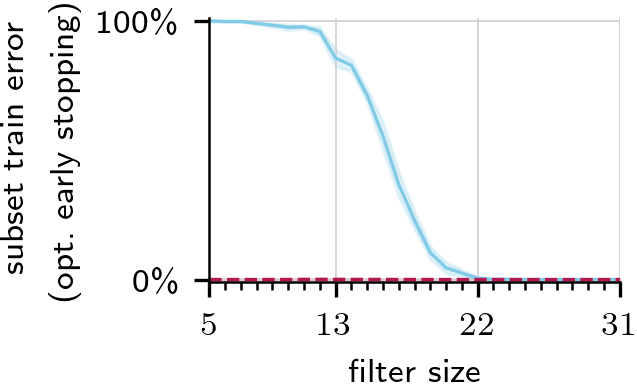

In [9]:
fig, ax = plt.subplots(
    figsize=(
        plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5] / plot_util.GOLDEN_RATIO
    )
)

df_es_train_error = df_agg.loc[df_agg.network_width == 128].drop(
    ["network_width"], axis=1
).groupby(["noise_fraction", "network_filter_size"]).agg(["mean", "sem"])
for noise_idx, noise_fraction in enumerate(df_es_train_error.index.get_level_values(0).unique()):
    if noise_fraction == "0.0":
        continue

    df_setting_noise = df_es_train_error.loc[noise_fraction]

    filter_size = df_setting_noise.index
    xs = filter_size

    ys_mean = 1.0 - df_setting_noise["es_train_noise_accuracy"]["mean"]
    ys_err = df_setting_noise["es_train_noise_accuracy"]["sem"]
    current_color = "C3"
    _, current_ls = NOISE_ES_STYLE_MAP["0.2"]["es"]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"noisy subset",
        ls=current_ls,
    )

    ys_mean = 1.0 - df_setting_noise["es_train_noiseless_accuracy"]["mean"]
    ys_err = df_setting_noise["es_train_noiseless_accuracy"]["sem"]
    current_color = "C2"
    _, current_ls = NOISE_ES_STYLE_MAP["0.0"]["es"]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"clean subset",
        ls=current_ls,
    )


ax.set_ylim(0.0 - 1e-2, 1.0 + 1e-2)
ax.set_yticks((
    0.0,
    1.0
))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))

ax.set_xlim(5, 31)
ax.set_xticks((5, 13, 22, 31))
ax.set_xlabel(r"filter size")
ax.set_ylabel(r"\noindent{}\;\;\;subset train error \\(opt.\ early stopping)")
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(tuple(range(5, 32))))

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "filters_error_es.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()
handles = [proxy_patch, handles[0], proxy_patch, handles[1]]
labels = ["", labels[0], "", labels[1]]

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[2],
))

legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    frameon=False,
    borderpad=0.5,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "filters_error_es_legend.pdf"))

plt.close(legend_fig)


## Example data samples

In [10]:
images_per_class = 2

with jax.default_device(jax.devices("cpu")[0]):
    dataset = data.ShapeDataset(
        image_size=32,
        shape_size=5,
        min_shape_size=3,
        num_shapes_per_sample=10,
        force_inside=True,
        use_squares=False,
        use_background=False,
        cache_dir=None,
    )
    xs, ys = dataset.generate_samples(2 * images_per_class, key=jax.random.PRNGKey(42))


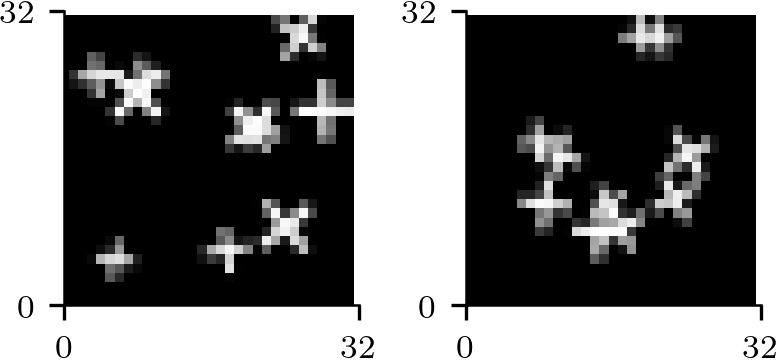

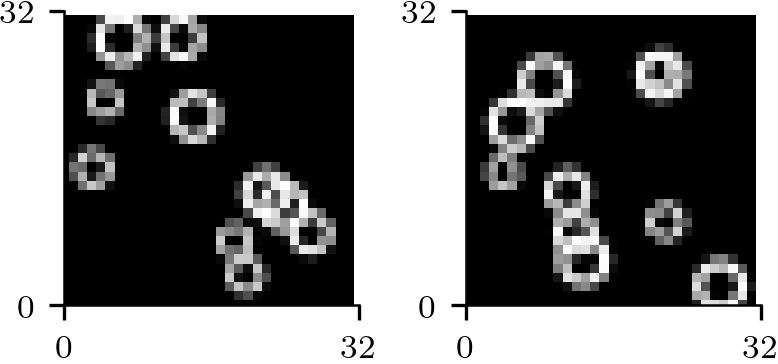

In [11]:
assert xs.shape == (2 * images_per_class, 32, 32, 1)
assert ys.shape == (2 * images_per_class, 1)

for idx, name in ((0, "positive"), (1, "negative")):
    fig, axes = plt.subplots(
        1, images_per_class,
        figsize=(
            plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO
        )
    )
    for img_idx in range(images_per_class):
        ax = axes[img_idx]
        ax.imshow(
            xs[idx * images_per_class + img_idx, :, :, 0], cmap="gray"
        )
        ax.grid(visible=False)
        ax.set_xticks((0, 32))
        ax.set_yticks((0, 32))
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)

    plt.show()

    fig.savefig(os.path.join(PLOT_BASE_DIR, f"filters_data_{name}.pdf"))

    plt.close(fig)


## Difference to double descent

In [12]:
diff_xrange = (5, 27)
diff_xticks = (5, 13, 23, 27)
diff_xticks_minor = (5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 27)
diff_markersize = 24
DIFF_EXTENDED_WIDTH_STYLE = {
    1024: ("none", "C4", "o"),
    2048: ("C5", None, "x"),
}
DIFF_EXTENDED_NOISE_LS = {
    "0.0": (1, (2, 1)),
    "0.2": plot_util.LINESTYLE_MAP[0],
}
DIFF_EXTENDED_MODEL_LS = {
    "es": (1, (2, 1)),
    "int": plot_util.LINESTYLE_MAP[0],
}

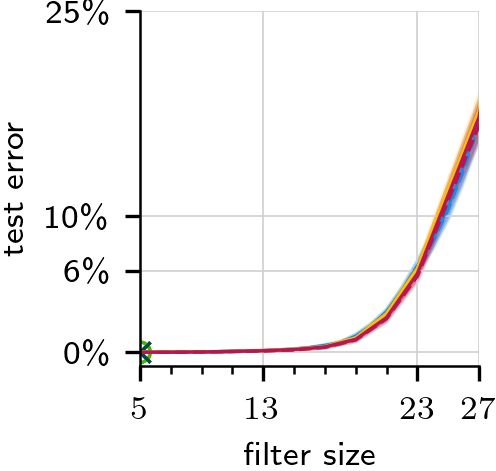

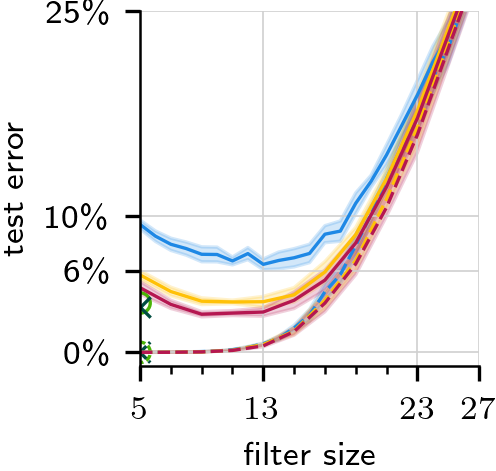

In [13]:
for noise_fraction, noise_label in {"0.0": "_noiseless", "0.2": ""}.items():
    fig, ax = plt.subplots(
        figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO)
    )

    df_ablation_error = df_agg[df_agg.noise_fraction == noise_fraction].drop("noise_fraction", axis=1).groupby(
        ["network_width", "network_filter_size"]
    ).agg(["mean", "sem"])
    for width_idx, width in enumerate(df_ablation_error.index.get_level_values(0).unique()):
        df_setting_width = df_ablation_error.loc[width]
        filter_size = df_setting_width.index
        xs = filter_size
        if width in DIFF_EXTENDED_WIDTH_STYLE.keys():
            current_facecolor, current_edgecolor, current_marker = DIFF_EXTENDED_WIDTH_STYLE[width]

            ys_mean = 1.0 - df_setting_width["test_accuracy"]["mean"]
            current_ls = DIFF_EXTENDED_MODEL_LS["int"]
            ax.scatter(
                x=xs, y=ys_mean,
                marker=current_marker, s=diff_markersize,
                edgecolors=current_edgecolor, facecolors=current_facecolor,
                label=fr"{width}",
                ls=current_ls,
            )

            ys_mean = 1.0 - df_setting_width["best_test_accuracy"]["mean"]
            current_ls = DIFF_EXTENDED_MODEL_LS["es"]
            ax.scatter(
                x=xs, y=ys_mean,
                marker=current_marker, s=diff_markersize,
                edgecolors=current_edgecolor, facecolors=current_facecolor,
                label=fr"{width}",
                ls=current_ls,
            )
        else:
            ys_mean = 1.0 - df_setting_width["test_accuracy"]["mean"]
            ys_err = df_setting_width["test_accuracy"]["sem"]
            current_color, current_ls = ABLATION_MODEL_STYLE_MAP["int"][width_idx]
            ax.fill_between(
                xs,
                ys_mean - ys_err,
                ys_mean + ys_err,
                color=current_color,
                alpha=0.2,
            )
            ax.plot(
                xs,
                ys_mean,
                c=current_color,
                label=fr"{width}",
                ls=current_ls,
            )

            ys_mean = 1.0 - df_setting_width["best_test_accuracy"]["mean"]
            ys_err = df_setting_width["best_test_accuracy"]["sem"]
            current_color, current_ls = ABLATION_MODEL_STYLE_MAP["es"][width_idx]
            ax.fill_between(
                xs,
                ys_mean - ys_err,
                ys_mean + ys_err,
                color=current_color,
                alpha=0.2,
            )
            ax.plot(
                xs, ys_mean,
                c=current_color,
                label=fr"{width}",
                ls=current_ls,
            )

    ax.set_ylim(0.0 - 1e-2, 0.25)
    ax.set_yticks((
        0.0,
        0.06,
        0.1,
        0.25,
    ))
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))
    ax.set_ylabel("test error")

    ax.set_xlim(*diff_xrange)
    ax.set_xticks(diff_xticks)
    ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(diff_xticks_minor))
    ax.set_xlabel(r"filter size")

    plt.show()

    fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_filters{noise_label}_error.pdf"))

    plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()

handles_int, labels_int = handles[::2], labels[::2]
handles_es, labels_es = handles[1::2], labels[1::2]

# Collect row-wise, then transpose since matplotlib is column-wise
handles_int = [proxy_patch] + handles_int[:3] + [proxy_patch] + handles_int[3:] + [proxy_patch]
labels_int = ["interpolating, width:"] + labels_int[:3] + [""] + labels_int[3:] + [""]
handles_es = [proxy_patch] + handles_es[:3] + [proxy_patch] + handles_es[3:] + [proxy_patch]
labels_es = ["optimally early-stopped, width:"] + labels_es[:3] + [""] + labels_es[3:] + [""]
handles_transposed = handles_int + handles_es
labels_transposed = labels_int + labels_es
handles = [handles_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(handles_transposed))]
labels = [labels_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(labels_transposed))]

legend_fig = plt.figure(figsize=(
    2 * plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))

legend_fig.legend(
    handles,
    labels,
    loc='center left',
    ncol=4,
    frameon=False,
    borderpad=0.5,
    handletextpad=0.5,
    columnspacing=0.8,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_filters_error_legend.pdf"))

plt.close(legend_fig)


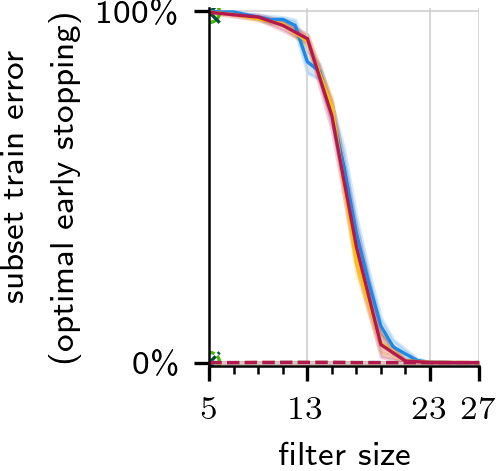

In [14]:
fig, ax = plt.subplots(
    figsize=(
        plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO
    )
)

df_ablation_es = df_agg[df_agg.noise_fraction == "0.2"].drop("noise_fraction", axis=1).groupby(
    ["network_width", "network_filter_size"]
).agg(["mean", "sem"])
for width_idx, width in enumerate(df_ablation_es.index.get_level_values(0).unique()):
    df_setting_width = df_ablation_es.loc[width]
    filter_size = df_setting_width.index
    xs = filter_size

    if width in DIFF_EXTENDED_WIDTH_STYLE.keys():
        current_facecolor, current_edgecolor, current_marker = DIFF_EXTENDED_WIDTH_STYLE[width]

        ys_mean = 1.0 - df_setting_width["es_train_noise_accuracy"]["mean"]
        noise_level, = filter(lambda noise: noise != "0.0", DIFF_EXTENDED_NOISE_LS.keys())
        current_ls = DIFF_EXTENDED_NOISE_LS[noise_level]
        ax.scatter(
            x=xs, y=ys_mean,
            marker=current_marker, s=diff_markersize,
            edgecolors=current_edgecolor, facecolors=current_facecolor,
            label=fr"{width}",
            ls=current_ls,
        )

        ys_mean = 1.0 - df_setting_width["es_train_noiseless_accuracy"]["mean"]
        current_ls = DIFF_EXTENDED_NOISE_LS["0.0"]
        ax.scatter(
            x=xs, y=ys_mean,
            marker=current_marker, s=diff_markersize,
            edgecolors=current_edgecolor, facecolors=current_facecolor,
            label=fr"{width}",
            ls=current_ls,
        )
    else:
        ys_mean = 1.0 - df_setting_width["es_train_noise_accuracy"]["mean"]
        ys_err = df_setting_width["es_train_noise_accuracy"]["sem"]
        current_color, current_ls = ABLATION_MODEL_STYLE_MAP["int"][width_idx]
        ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
        ax.plot(
            xs,
            ys_mean,
            c=current_color,
            label=fr"{width}",
            ls=current_ls,
        )

        ys_mean = 1.0 - df_setting_width["es_train_noiseless_accuracy"]["mean"]
        ys_err = df_setting_width["es_train_noiseless_accuracy"]["sem"]
        current_color, current_ls = ABLATION_MODEL_STYLE_MAP["es"][width_idx]
        ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
        ax.plot(
            xs,
            ys_mean,
            c=current_color,
            label=fr"{width}",
            ls=current_ls,
        )

ax.set_ylim(0.0 - 1e-2, 1.0 + 1e-2)
ax.set_yticks((
    0.0,
    1.0
))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))
ax.set_ylabel(r"subset train error \\(optimal early stopping)")

ax.set_xlim(*diff_xrange)
ax.set_xticks(diff_xticks)
ax.set_xlabel(r"filter size")
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(diff_xticks_minor))

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_filters_es.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()

handles_noisy, labels_noisy = handles[::2], labels[::2]
handles_clean, labels_clean = handles[1::2], labels[1::2]

# Collect row-wise, then transpose since matplotlib is column-wise
handles_noisy = [proxy_patch] + handles_noisy[:3] + [proxy_patch] + handles_noisy[3:] + [proxy_patch]
labels_noisy = ["noisy:"] + labels_noisy[:3] + [""] + labels_noisy[3:] + [""]
handles_clean = [proxy_patch] + handles_clean[:3] + [proxy_patch] + handles_clean[3:] + [proxy_patch]
labels_clean = ["clean:"] + labels_clean[:3] + [""] + labels_clean[3:] + [""]
handles_transposed = handles_noisy + handles_clean
labels_transposed = labels_noisy + labels_clean
handles = [handles_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(handles_transposed))]
labels = [labels_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(labels_transposed))]

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))

legend_fig.legend(
    handles,
    labels,
    loc='center right',
    ncol=4,
    frameon=False,
    borderpad=0.5,
    handletextpad=0.4,
    columnspacing=0.7,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_filters_es_legend.pdf"))

plt.close(legend_fig)


## Training losses

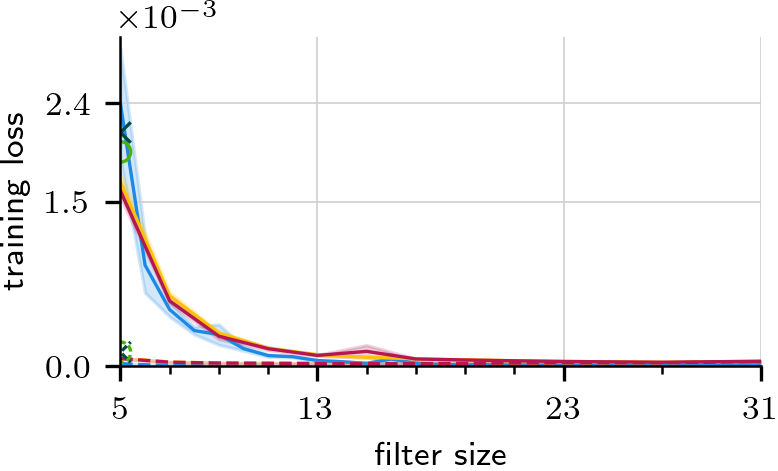

In [15]:
fig, ax = plt.subplots(
    figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO)
)

for width_idx, network_width in enumerate((128, 256, 512, 1024, 2048)):
    df_test_error = df_agg.loc[df_agg.network_width == network_width].drop(
        ["network_width"], axis=1
    ).groupby(["noise_fraction", "network_filter_size"]).agg(["mean", "sem"])
    for noise_idx, noise_fraction in enumerate(df_test_error.index.get_level_values(0).unique()):
        df_setting_noise = df_test_error.loc[noise_fraction]
        filter_size = df_setting_noise.index
        xs = filter_size
        current_color, current_ls = ABLATION_NOISE_STYLE_MAP[noise_fraction][width_idx]
        ys_mean = df_setting_noise["train_loss"]["mean"]
        ys_err = df_setting_noise["train_loss"]["sem"]

        if network_width in DIFF_EXTENDED_WIDTH_STYLE.keys():
            current_facecolor, current_edgecolor, current_marker = DIFF_EXTENDED_WIDTH_STYLE[network_width]
            current_ls = DIFF_EXTENDED_NOISE_LS[noise_fraction]

            ax.scatter(
                x=xs,
                y=ys_mean,
                marker=current_marker,
                s=diff_markersize,
                ls=current_ls,
                edgecolors=current_edgecolor,
                facecolors=current_facecolor,
                label=fr"{network_width}",
                zorder=2.0
            )

        else:
            ax.fill_between(
                xs,
                ys_mean - ys_err,
                ys_mean + ys_err,
                color=current_color,
                alpha=0.2,
            )
            ax.plot(
                xs,
                ys_mean,
                c=current_color,
                label=fr"{network_width}",
                ls=current_ls,
            )

ax.set_ylim(0.0, 3e-3)
ax.set_yticks((
    0.0,
    1.5e-3,
    2.4e-3,
))
ax.ticklabel_format(style="sci", scilimits=(0, 0), axis="y")
ax.set_xlim(5, 31)
ax.set_xticks((5, 13, 23, 31))
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator((5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 27, 31)))

ax.set_xlabel(r"filter size")
ax.set_ylabel("training loss")
plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "loss_filters.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()

handles_clean, labels_clean = handles[::2], labels[::2]
handles_noisy, labels_noisy = handles[1::2], labels[1::2]

# Collect row-wise, then transpose since matplotlib is column-wise
handles_clean = [proxy_patch] + handles_clean[:3] + [proxy_patch] + handles_clean[3:] + [proxy_patch]
labels_clean = [r"0\% noise, width:"] + labels_clean[:3] + [""] + labels_clean[3:] + [""]
handles_noisy = [proxy_patch] + handles_noisy[:3] + [proxy_patch] + handles_noisy[3:] + [proxy_patch]
labels_noisy = [r"20\% noise, width:"] + labels_noisy[:3] + [""] + labels_noisy[3:] + [""]
handles_transposed = handles_clean + handles_noisy
labels_transposed = labels_clean + labels_noisy
handles = [handles_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(handles_transposed))]
labels = [labels_transposed[4 * (idx % 4) + idx // 4] for idx in range(len(labels_transposed))]

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))
legend_fig.legend(
    handles,
    labels,
    loc='center right',
    ncol=4,
    frameon=False,
    borderpad=0.5,
    handletextpad=0.3,
    columnspacing=0.7,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "loss_filters_legend.pdf"))

plt.close(legend_fig)
